In [1]:
import pandas as pd
import numpy as np
import networkx
import networkx.convert_matrix as nx
import pyvis
import graphviz
from pyvis.network import Network
import pyvis.network as net
import pydot
import random
# https://towardsdatascience.com/social-network-analysis-from-theory-to-applications-with-python-d12e9a34c2c7
# https://github.com/ewenme/transfers
# https://towardsdatascience.com/visualizing-networks-in-python-d70f4cbeb259
# https://github.com/MridulS/pydata-networkx

import sys
!{sys.executable} -m pip install pydot

In [2]:
BuLi19 = pd.read_csv("2019_german_bundesliga_1.csv")
PL19 = pd.read_csv("2019_english_premier_league.csv")
SA19 = pd.read_csv("2019_italian_serie_a.csv")
PD19 = pd.read_csv("2019_spanish_primera_division.csv")
L1_19 = pd.read_csv("2019_french_ligue_1.csv")

In [3]:
DF19 = pd.concat([BuLi19, PL19, SA19, PD19, L1_19])

In [4]:
DF19.shape

(4126, 12)

## Clean the Data

In [5]:
def DelCol(DF):
    DF = DF.loc[DF["transfer_movement"]=="in"] # only one direction of transfers should be considered
    DF = DF.loc[DF["fee_cleaned"]>0] # only "real" transfers
    del DF["player_name"]
    del DF["transfer_movement"]
    del DF["age"]
    del DF["position"]
    del DF["fee"]
    del DF["league_name"]
    del DF["transfer_period"]
    del DF["year"]
    del DF["season"]
    return(DF)



In [6]:
DF19 = DelCol(DF19)

In [7]:
BuLi19["colour"] = "red"
print(BuLi19)

             club_name        player_name  age            position  \
0        Bayern Munich    Lucas Hernández   23         Centre-Back   
1        Bayern Munich    Benjamin Pavard   23          Right-Back   
2        Bayern Munich   Michaël Cuisance   20    Central Midfield   
3        Bayern Munich  Philippe Coutinho   27  Attacking Midfield   
4        Bayern Munich       Ivan Perisic   30         Left Winger   
..                 ...                ...  ...                 ...   
585  1.FC Union Berlin        Yunus Malli   27  Attacking Midfield   
586  1.FC Union Berlin      Lennart Moser   20          Goalkeeper   
587  1.FC Union Berlin    Lennard Maloney   20         Centre-Back   
588  1.FC Union Berlin       Nicolai Rapp   23         Centre-Back   
589  1.FC Union Berlin      Lennart Moser   20          Goalkeeper   

    club_involved_name                      fee transfer_movement  \
0      Atlético Madrid                  £72.00m                in   
1        VfB Stuttgar

### Combine multiple transfers between clubs a and b

In [231]:
# now as a function
        
def AddFees(DF): # adds fees of multiple transfers from club a to b
    # output
    DF_out = pd.DataFrame({'club_name' : [],
                         "club_involved_name":[],
                         "fee_cleaned":[]})
    
    for i in range(DF.shape[0]):
        # is this a new match?
        if DF_out.loc[(DF_out["club_name"]== DF["club_name"].iloc[i])&  
                     DF_out["club_involved_name"].isin([DF["club_involved_name"].iloc[i]])].size ==0:
            DF_out = DF_out.append(DF.iloc[i])
        else:
            # add fee value to already existing value
            DF_out["fee_cleaned"].loc[(DF_out["club_name"]== DF["club_name"].iloc[i])&  
                     DF_out["club_involved_name"].isin([DF["club_involved_name"].iloc[i]])] += DF["fee_cleaned"].iloc[i]
            
    return(DF_out)    
        

In [234]:
DF19 = AddFees(DF19)

/home/users/t_wand01/.local/lib/python3.7/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [235]:
DF19

,club_name,club_involved_name,fee_cleaned
0,Bayern Munich,Atlético Madrid,72.00
1,Bayern Munich,VfB Stuttgart,31.50
2,Bayern Munich,Bor. M'gladbach,10.80
3,Bayern Munich,FC Barcelona,7.65
4,Bayern Munich,Inter,4.50
...,...,...,...
681,AS Monaco,AJ Auxerre,9.00
682,AS Monaco,Legia Warszawa,6.30
700,FC Nantes,Standard Liège,3.60
715,Stade Reims,Ajax U21,3.60


# Graphs

In [8]:
G = nx.from_pandas_edgelist(DF19, 
                            source = "club_name",
                            target = "club_involved_name",
                            edge_attr=["fee_cleaned"],#, "colour"],
                            create_using=networkx.DiGraph()
                           )

In [48]:
# Teams of individual leagues 19/20
BL19_teams = list(set(BuLi19["club_name"])) # Bundesliga
BL19List = pd.Series(BL19_teams)


l = ["red", "blue"]
print(len(G.nodes))
Colours = random.choices(l, k=len(G.nodes))

In [51]:
Colours = ["none"]*len(G.nodes)
j = 0
for i in G.nodes:
    if np.sum(BL19List.isin([i])) > 0: # if Bundesliga-Team
        Colours[j] = "red"
    j = j+1

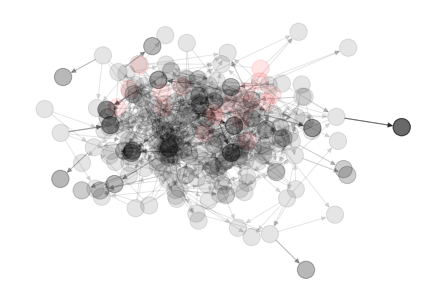

In [52]:
networkx.draw_kamada_kawai(G,node_color = Colours, with_labels=False, alpha=0.1)

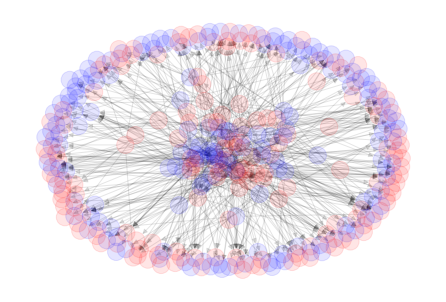

In [29]:
networkx.draw_spring(G,node_color = Colours, with_labels=False, alpha = 0.1)

In [12]:
net = Network(notebook=True)
net.from_nx(G)
net.show("Test.html")
# net.save_graph("Test.html")

## Pyvis

In [117]:
g = Network(notebook=True)

g.add_nodes(np.array(G.nodes), 
            color = random.choices(["red","grey"], k=len(G.nodes)),
            options = {
                "title":"lel"
            })

In [118]:
# https://www.hexcolortool.com/#f40f0b,0.33
for node in G.nodes:
    g.add_node(str(node), color = "rgba(244, 15, 11, 0.33)", alpha=0.1,
              options = {
              })

In [119]:
#var options = {
# "nodes": {
#    "color": {
#      "border": "rgba(43,124,233,0.46)",
#      "background": "rgba(90,65,252,0.51)"
#    }
#  },
#  "edges": {
#    "color": {
#      "inherit": true
#    },
#    "smooth": false
#  },
#  "physics": {
# "enabled": false,
#    "repulsion": {
#     "springLength": 500
#   },
#    "minVelocity": 0.75,
#    "solver": "repulsion"
#  }
#}

In [120]:
#g.add_edges(DF19["club_name"],DF19["club_involved_name"], value =DF19["fee_cleaned"])

In [121]:
for i in range(DF19.shape[0]):
    g.add_edge(DF19["club_name"].iloc[i], 
              DF19["club_involved_name"].iloc[i],
              value=DF19["fee_cleaned"].iloc[i], 
            kwargs ={
               "physics":False
           })


In [122]:
g.show("Test.html")

In [77]:
g.save_graph("Test2.html")

In [60]:
DF19.shape[0]

655

## Small directed test

In [143]:
g = Network(notebook=True)
g.add_node("FCB", color = "rgba(244, 15, 11, 0.33)", alpha=0.1,
              options = {
              })
g.add_node("S04",color = "rgba(11, 85, 244, 0.33)", alpha=0.1,
              options = {
              })
g.add_node("BVB",color = "rgba(224, 244, 11, 0.33)", alpha=0.1,
              options = {
              })
#g.add_edge("FCB","S04",value=10, 
#            kwargs ={
#               "physics":False
 #          })
g.add_edge("S04","FCB",value=10, 
            kwargs ={
               "physics":False
           })
g.add_edge("BVB","FCB",value=1, 
            kwargs ={
               "physics":False
           })
g.add_edge("FCB","BVB",value=10, 
            kwargs ={
               "physics":False
           })

In [144]:
g.show("SmallTest.html")

## Colours

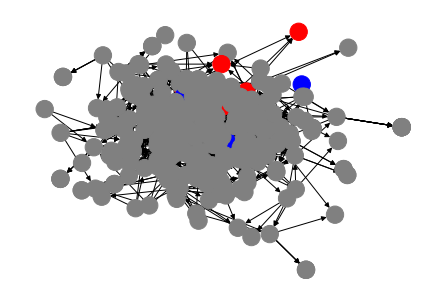

In [30]:
BuLi19Lst = ["Bayern Munich", "Bor. M'gladbach", "Borussia Dortmund", "TSG Hoffenheim", "Bay. Leverkusen"]
BuLi19Lst = pd.Series(BuLi19Lst)
PL19Lst = ["Manchester City","Liverpool FC","Chelsea FC"  ]
PL19Lst = pd.Series(PL19Lst)
color_map = []

for node in G:
    if (np.sum(BuLi19Lst.isin([node])) == 0 and np.sum(PL19Lst.isin([node]))==0): # keine Bundesliga
        color_map.append("grey")
    elif np.sum(PL19Lst.isin([node])) > 0:
        color_map.append("blue")
    elif (np.sum(BuLi19Lst.isin([node])) > 0): 
        color_map.append('red')
        

networkx.draw_kamada_kawai(G, node_color = color_map,with_labels=False)

In [45]:
# Colours
BuLi19Lst= ["Bayern Munich", "Bor. M'gladbach", "Borussia Dortmund", "TSG Hoffenheim", "Bay. Leverkusen"]
BuLi19Lst = pd.Series(BuLi19Lst)
#print(BuLi19Lst)
color_map = []

for node in G:
    if np.sum(BuLi19Lst.isin([node])) == 0: # keine Bundesliga
        color_map.append("blue")
    else: 
        color_map.append('red')

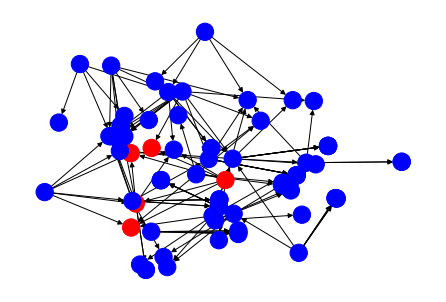

In [78]:
networkx.draw_kamada_kawai(G, node_color = color_map,with_labels=False)

In [57]:
# Create a pd.Series of the nodes

nodes = set(BuLi19["club_name"]) | set(BuLi19["club_involved_name"])
print(len(nodes))
nodes= np.array(nodes)
nodes = pd.Series(nodes)#, np.arange(len(nodes)))
print(nodes)

83
0    {'Everton', 'Paris SG', 'Hamburger SV', 'Våler...
dtype: object


In [79]:
## pyvis
from pyvis.network import Network
net = Network(notebook=True)
net.from_nx(G)
net.show("Test.html")
# net.save_graph("Test.html")


In [ ]:
# https://pyvis.readthedocs.io/en/latest/tutorial.html

## Analysis

In [18]:
G_undir = nx.from_pandas_edgelist(BuLi19, 
                            source = "club_name",
                            target = "club_involved_name",
                            edge_attr="fee_cleaned"
                           )

In [19]:
from networkx.algorithms import approximation

approximation.average_clustering(G_undir, trials=1000, seed=10)

0.041

# Test: verschiedene Farben

In [25]:
networkx.draw_networkx_nodes(G, nodelist=[0,1,2], node_color="tab:red", **options)
#networkx.draw_networkx_nodes(G, pos, nodelist=[50:114], node_color="tab:blue", **options)

# edges
#networkx.draw_networkx_edges(G, pos, width=1.0, alpha=0.5)

NameError: name 'options' is not defined

In [67]:
type(nodes)

pandas.core.series.Series

In [60]:
edges = BuLi19[["club_name", "club_involved_name", "fee_cleaned"]]

In [64]:
from pyvis.network import Network
net = Network()
net.add_nodes(nodes[0], color = BuLi19["colour"])
net.add_edge()

TypeError: len() of unsized object

In [77]:
from pyvis.network import Network

g = Network()
g.add_nodes([1,2,3], value=[10, 100, 400],
                         label=['NODE 1', 'NODE 2', 'NODE 3'],
                         color=['red', "blue", "green"])
g.add_edge(1,2,weight=0.5)
g.show("Test.html")